In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import sys

sys.path.append("..")
from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [2]:
var_list = [
    Variable(name="Y", description="Output", positive=True),
    Variable(name="C", description="Consumption", positive=True),
    Variable(name="INC", description="Household income", latex_name="Omega", positive=True),
    Variable(name="L_d", description="Firm demand for labor", positive=True),
    Variable(name="K_d", description="Firm demand for capital", positive=True),
    Variable(name="r", description="Rental rate of capital", positive=True),
    Variable(name="w", description="Wage level", positive=True),
    Variable(name="P", description="Price level", positive=True),
    Variable(name="resid", latex_name="varepsilon", description="Walrasian residual"),
]

param_list = [
    Parameter(name="L_s", description="Household labor supply"),
    Parameter(name="K_s", description="Household capital supply"),
    Parameter(name="A", description="Total factor productivity"),
    Parameter(name="psi", description="Elasticity of substitution between capital and labor"),
    Parameter(name="alpha", description="Share of capital in production"),
    Parameter(name="w_bar", latex_name=r"\bar{w}", description="Numeraire wage level"),
]

equation_list = [
    # Firm equations
    Equation(
        name="Production function",
        equation="Y = A * (alpha * K_d ** ((psi - 1) / psi) + (1 - alpha) * L_d ** ((psi - 1) / psi)) ** (psi / (psi - 1))",
    ),
    Equation(name="Capital demand", equation="K_d = Y / A * (alpha * A * P / r) ** psi"),
    Equation(name="Labor demand", equation="L_d = Y / A * ((1 - alpha) * A * P / w) ** psi"),
    # Household equatons
    Equation(name="Household income", equation="INC = w * L_s + r * K_s"),
    Equation(name="Household budget constraint", equation="P * C = INC"),
    # Equlibrium conditions
    Equation(name="Economic resource constraint", equation="Y = C"),
    Equation(name="Labor market clearing", equation="L_s = L_d + resid"),
    Equation(name="Capital market clearing", equation="K_s = K_d"),
    Equation(name="Numeraire wage", equation="w = w_bar"),
]

In [41]:
mod = CGEModel(
    variables=var_list,
    parameters=param_list,
    equations=equation_list,
    parse_equations_to_sympy=False,
    backend="pytensor",
)

In [44]:
mod.f_system.maker.inputs

[In(Y),
 In(C),
 In(INC),
 In(L_d),
 In(K_d),
 In(r),
 In(w),
 In(P),
 In(resid),
 In(L_s),
 In(K_s),
 In(A),
 In(psi),
 In(alpha),
 In(w_bar)]

In [4]:
mod.summary()

<IPython.core.display.Latex object>

In [5]:
mod.equation_table()

<IPython.core.display.Latex object>

In [6]:
data = {"L_s": 7000, "K_s": 4000, "P": 1, "r": 1, "w_bar": 1, "psi": 30}


def calibrate_model(L_s, K_s, P, r, psi, w_bar):
    calib_dict = {"L_s": L_s, "K_s": K_s, "P": P, "r": r, "w_bar": w_bar, "psi": psi}

    # Numeraire
    w = w_bar

    INC = w * L_s + r * K_s
    C = INC / P
    Y = C
    K_d = K_s
    L_d = L_s

    alpha = r * K_d ** (1 / psi) / (r * K_d ** (1 / psi) + w * L_d ** (1 / psi))
    A = Y * (alpha * K_d ** ((psi - 1) / psi) + (1 - alpha) * L_d ** ((psi - 1) / psi)) ** (
        -psi / (psi - 1)
    )
    resid = L_d - L_s

    calib_dict["w"] = w
    calib_dict["INC"] = INC
    calib_dict["C"] = C
    calib_dict["Y"] = Y
    calib_dict["K_d"] = K_d
    calib_dict["L_d"] = L_d
    calib_dict["alpha"] = alpha
    calib_dict["A"] = A
    calib_dict["resid"] = resid

    return calib_dict

In [7]:
calibated_data = calibrate_model(**data)

In [8]:
calibated_data

{'L_s': 7000,
 'K_s': 4000,
 'P': 1,
 'r': 1,
 'w_bar': 1,
 'psi': 30,
 'w': 1,
 'INC': 11000,
 'C': 11000.0,
 'Y': 11000.0,
 'K_d': 4000,
 'L_d': 7000,
 'alpha': 0.49533667032328754,
 'A': 1.9974264171314797,
 'resid': 0}

In [13]:
labor_increase = calibated_data.copy()
labor_increase["L_s"] = 10_000
theta_labor_increase = np.array([labor_increase[x] for x in mod.parameter_names], dtype=float)
theta_labor_increase
idata = mod._solve_with_euler_approximation(
    calibated_data, theta_final=theta_labor_increase, n_steps=100_000
)

In [40]:
mod.f_system()

TypeError: too many arguments: expected 2, got 15

In [14]:
res = mod._solve_with_root(calibated_data, theta_labor_increase)
res.success

True

In [38]:
idata.parameters.isel(step=-1).to_array().values

array([1.00000000e+04, 4.00000000e+03, 1.99742642e+00, 3.00000000e+01,
       4.95336670e-01, 1.00000000e+00])

NameError: name 'idata' is not defined

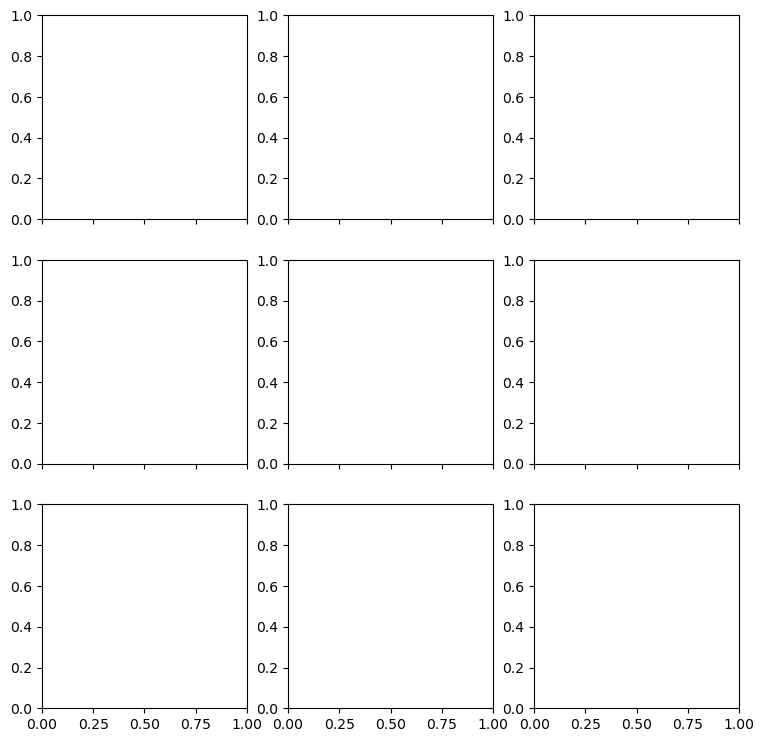

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    idata.variables[var].plot(x="step", ax=axis)
    axis.set(title=var, xlabel=None)
    axis.scatter(
        idata.variables.coords["step"].max(),
        res.x[i],
        marker="*",
        color="tab:red",
        zorder=10,
        s=100,
    )
fig.tight_layout()